In [31]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_prominences
from scipy.ndimage import gaussian_filter1d
#from scipy.stats import landau
from scipy.signal import fftconvolve
from landaupy import landau, langauss


FADC_BIN_WIDTH = 1


In [32]:
def load_pmt(input_file,pmtname, minnpe = 0.): 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    pmt_em = data.query("id == 1 or id == 2 or id == -2")[pmtname]
    pmt_mu = data.query("id == 3 or id == -3")[pmtname]

    pmt_mu = np.asarray(pmt_mu[pmt_mu >= minnpe])
    pmt_em = np.asarray(pmt_em[pmt_em >= minnpe])
    pmt_tot = np.concatenate((pmt_mu,pmt_em))
    
    return pmt_tot

def load_top_sum_fadc_pmt(input_file, minnpe = 0.): 
    data=pd.read_csv(input_file, sep ='\t',header=None)
    data.columns = ["num","id", "energy", "pmt1", "pmt2", "pmt3", "pmt4", "pmt1_FADC", "pmt2_FADC", "pmt3_FADC", "pmt4_FADC"]
    pmt_em_1 = data.query("id == 1 or id == 2 or id == -2")['pmt1_FADC']
    pmt_mu_1 = data.query("id == 3 or id == -3")['pmt1_FADC']
    pmt_em_2 = data.query("id == 1 or id == 2 or id == -2")['pmt2_FADC']
    pmt_mu_2 = data.query("id == 3 or id == -3")['pmt2_FADC']
    pmt_em_3 = data.query("id == 1 or id == 2 or id == -2")['pmt3_FADC']
    pmt_mu_3 = data.query("id == 3 or id == -3")['pmt3_FADC']

    pmt_mu_1 = np.asarray(pmt_mu_1[pmt_mu_1 >= minnpe])
    pmt_em_1 = np.asarray(pmt_em_1[pmt_em_1 >= minnpe])
    pmt_tot_1 = np.concatenate((pmt_mu_1,pmt_em_1))

    pmt_mu_2 = np.asarray(pmt_mu_2[pmt_mu_2 >= minnpe])
    pmt_em_2 = np.asarray(pmt_em_2[pmt_em_2 >= minnpe])
    pmt_tot_2 = np.concatenate((pmt_mu_2,pmt_em_2))

    pmt_mu_3 = np.asarray(pmt_mu_3[pmt_mu_3 >= minnpe])
    pmt_em_3 = np.asarray(pmt_em_3[pmt_em_3 >= minnpe])
    pmt_tot_3 = np.concatenate((pmt_mu_3,pmt_em_3))

    pmt_tot = np.concatenate((pmt_tot_1, pmt_tot_2, pmt_tot_3))
    
    return pmt_tot

In [33]:

# Gaussian function for fitting
def gaussian(x, A, mu, sigma):
    return A * norm.pdf(x, mu, sigma)

def landau_func(x, A, mu, sigma): 
    return A * landau.pdf(x,mu,sigma)

def pol_2(x, p0, p1, p2): 
    return p0 * x * x + p1 * x + p2 

def landau_conv_gaussian(x, A, mu_landau, width_landau, sigma_gauss): 
    f_landau = landau.pdf(x,mu_landau, width_landau)
    f_gaus = norm.pdf(x,loc=0, scale=sigma_gauss)
    #return A * fftconvolve(f_landau, f_gaus, mode='same')
    return A * langauss.pdf(x,landau_x_mpv=mu_landau, landau_xi = width_landau, gauss_sigma = sigma_gauss)


# Define funciton to perform Gaussian fit of the peak 
fadc_bins = np.arange(0,1000,1)

def gaussian_fit(input_array, fadc_bins, range_low, range_hi, low_count_threshold):

    # Build histogram ignoring low FADC counts (to remove em peak)
    entries, bin = np.histogram(input_array[input_array > low_count_threshold], bins=fadc_bins)
    arg_fadc_muon_mx = np.argmax(entries)
    print('FADC bin with largest entries ',fadc_bins[arg_fadc_muon_mx])

    fadc_low = fadc_bins[arg_fadc_muon_mx] - range_low
    fadc_hi = fadc_bins[arg_fadc_muon_mx] + range_hi

    range = [fadc_low, fadc_hi]

    # Perform fit on histogram with restricted range 
    array_to_fit = input_array[(input_array > fadc_low) & (input_array < fadc_hi)]

    entries_fit, bin_fit = np.histogram(array_to_fit, bins=fadc_bins)
    sigma_entries_fit = np.sqrt(entries_fit)
    sigma_entries_fit[sigma_entries_fit == 0] = 1e-6  # avoid zero division

    bin_centers = (bin_fit[:-1] + bin_fit[1:]) / 2.
    bin_width = bin_fit[1] - bin_fit[0] 

    # First guess for Gaussian parameters 
    p0 = [max(array_to_fit), np.mean(array_to_fit), 2.5*np.std(array_to_fit)]
    print('First guess ',p0)
    bounds = ([0, -np.inf, 1e-6], [np.inf, np.inf, np.inf])

    #array_to_fit = input_array[(input_array > 1.5*np.std(array_to_fit)) & (input_array < 2.5*np.std(array_to_fit))]

    #popt, pcov = curve_fit(gaussian, bin_centers, entries_fit, p0=p0, bounds = bounds, sigma = sigma_entries_fit, absolute_sigma=True)
    popt, pcov = curve_fit(gaussian, bin_centers, entries_fit, p0=p0)

    # Extract parameter estimates
    A_fit, mu_fit, sigma_fit = popt

    # Compute standard errors (uncertainties)
    perr = np.sqrt(np.diag(pcov))
    A_err, mu_err, sigma_err = perr


    return popt, perr, range 


def pol2_fit(input_array, fadc_bins, range_low, range_hi, low_count_threshold):

    # Build histogram ignoring low FADC counts (to remove em peak)
    entries, bin = np.histogram(input_array[input_array > low_count_threshold], bins=fadc_bins)
    arg_fadc_muon_mx = np.argmax(entries)
    print('FADC bin with largest entries ',fadc_bins[arg_fadc_muon_mx])

    fadc_low = fadc_bins[arg_fadc_muon_mx] - range_low
    fadc_hi = fadc_bins[arg_fadc_muon_mx] + range_hi

    range = [fadc_low, fadc_hi]

    # Perform fit on histogram with restricted range 
    array_to_fit = input_array[(input_array > fadc_low) & (input_array < fadc_hi)]

    fadc_bins_fit = np.arange(fadc_low, fadc_hi+1, FADC_BIN_WIDTH )

    entries_fit, bin_fit = np.histogram(array_to_fit, bins=fadc_bins_fit)

    bin_centers = (bin_fit[:-1] + bin_fit[1:]) / 2.
    bin_width = bin_fit[1] - bin_fit[0] 

    # First guess for pol2 parameters 
    p0 = np.polyfit(bin_centers, entries_fit, deg=2)
    print('First guess ',p0)

    popt, pcov = curve_fit(pol_2, bin_centers, entries_fit, p0=p0)

    # Compute standard errors (uncertainties)
    perr = np.sqrt(np.diag(pcov))

    popt = p0

    return popt, perr, range 

def landau_gaus_fit(input_array, fadc_bins, range_low, range_hi, low_count_threshold):

    # Build histogram ignoring low FADC counts (to remove em peak)
    entries, bin = np.histogram(input_array[input_array > low_count_threshold], bins=fadc_bins)
    arg_fadc_muon_mx = np.argmax(entries)
    print('FADC bin with largest entries ',fadc_bins[arg_fadc_muon_mx])

    fadc_low = fadc_bins[arg_fadc_muon_mx] - range_low
    fadc_hi = fadc_bins[arg_fadc_muon_mx] + range_hi

    range = [fadc_low, fadc_hi]

    # Perform fit on histogram with restricted range 
    array_to_fit = input_array[(input_array > fadc_low) & (input_array < fadc_hi)]
    fadc_bins_fit = np.arange(fadc_low, fadc_hi+1, FADC_BIN_WIDTH )

    entries_fit, bin_fit = np.histogram(array_to_fit, bins=fadc_bins_fit)
   
    bin_centers = (bin_fit[:-1] + bin_fit[1:]) / 2.
    bin_width = bin_fit[1] - bin_fit[0] 

    # First guess for Gaussian parameters 
    p0 = [max(array_to_fit), np.mean(array_to_fit), 2.5*np.std(array_to_fit), 1.*np.std(array_to_fit)]
    print('First guess ',p0)


    popt, pcov = curve_fit(landau_conv_gaussian, bin_centers, entries_fit, p0=p0)

    # Extract parameter estimates

    # Compute standard errors (uncertainties)
    perr = np.sqrt(np.diag(pcov))


    return popt, perr, range 




In [34]:
# Function to find minumum in a range defined by a lower limit and the peak maximum 

def find_valley(input_array, low_threshold, peak_position): 
    print('Looking for minimum between ',low_threshold,' and ', peak_position)
    array_formin = input_array[(input_array >low_threshold) & (input_array < peak_position)]

    bins = np.arange(low_threshold+2, int(peak_position),FADC_BIN_WIDTH)

    entries, bin = np.histogram(array_formin, bins=bins)
    fadc_min = np.argmin(entries)
    return bin[fadc_min]


Text(0, 0.5, 'Entries')

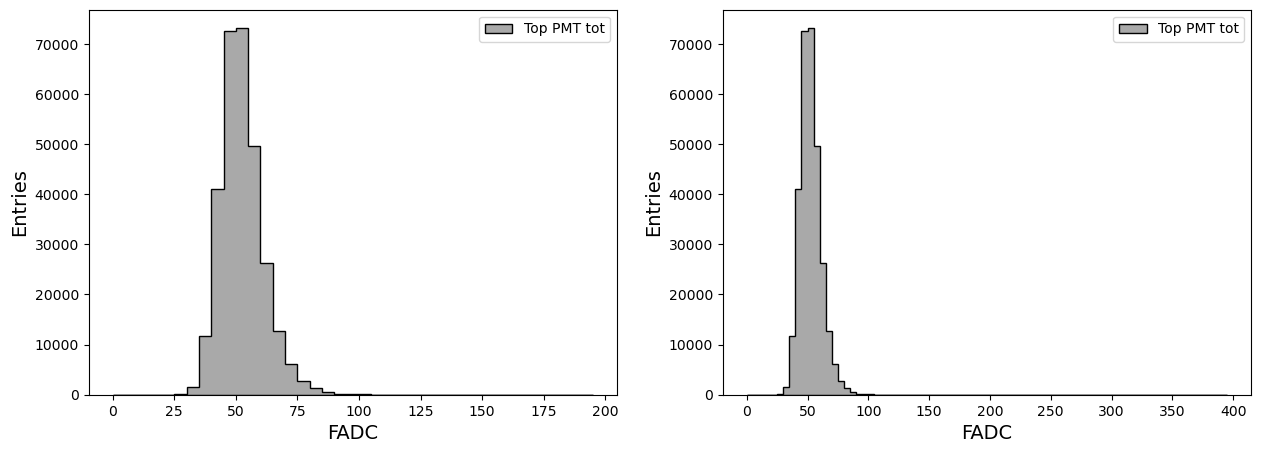

In [35]:
input_folder = '/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/'
input_files = ['top_30cm_VEM_0.50_3', 'top_35cm_VEM_0.50_3', 'top_40cm_VEM_0.50_3', 'top_45cm_VEM_0.50_3', 'top_50cm_VEM_0.50_3', 'top_55cm_VEM_0.50_3', 'top_60cm_VEM_0.50_3', 'top_65cm_VEM_0.50_3','top_70cm_VEM_0.50_3']

min_npe = 10.

plt.subplots(1,2,figsize=(15,5))

plt.subplot(1,2,1)
fadc_bins = np.arange(0,200,5)

pmt_tot = load_top_sum_fadc_pmt(input_folder+input_files[3])
#pmt_tot = load_pmt(input_folder+input_files[3],'pmt4_FADC',min_npe)[2]
plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
plt.legend()
plt.yscale('linear')
plt.xlabel('FADC',size=14)
plt.ylabel('Entries',size=14)


plt.subplot(1,2,2)
fadc_bins = np.arange(0,400,5)

plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
plt.legend()
plt.yscale('linear')
plt.xlabel('FADC',size=14)
plt.ylabel('Entries',size=14)


In [36]:
'''
input_folder = '/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/'
input_files = ['top_30cm_3', 'top_35cm_3', 'top_40cm_3', 'top_45cm_3', 'top_50cm_3', 'top_55cm_3', 'top_60cm_3', 'top_65cm_3','top_70cm_3']

min_npe = 0.

plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,400,FADC_BIN_WIDTH)
fadc_bin_centers = (fadc_bins_fit[:-1] + fadc_bins_fit[1:]) / 2.

low_count_threshold_array = [20, 20, 30, 30, 30, 30, 30, 30, 30]
low_count_threshold_array_min = [20, 20, 20, 30, 30, 30, 30, 30, 30]

range_width_low = [15, 15, 25, 20, 20, 30, 30, 30, 30]
range_width_hi = [50, 50, 50, 100, 100, 100, 100, 100, 100]

fadc_peak_bin = np.zeros(len(input_files))
rel_peak_err = np.zeros(len(input_files))
fadc_peak_entries = np.zeros(len(input_files))

fadc_min_bin = np.zeros(len(input_files))
fadc_min_entries = np.zeros(len(input_files))
for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_pmt(input_folder+file,"pmt4_FADC", minnpe=10)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    par, d_par, range = landau_gaus_fit(pmt_tot, fadc_bins_fit, range_low=range_width_low[i], range_hi=range_width_hi[i], low_count_threshold=low_count_threshold_array[i])
    A_fit, mu_fit, width_fit, sigma_fit = par
    A_err, mu_err, width_fit, sigma_err = d_par

    # Compute fitted curve
    x_fit = np.linspace(range[0], range[1], 1000)
    y_fit = landau_conv_gaussian(x_fit, *par)

    print('Result of Gaussian fit')

    print('A =',A_fit,' +-',A_err)
    print('mu =',mu_fit,' +-',mu_err)
    print('sigma =',sigma_fit,' +-',sigma_err)

    rel_peak_err[i] = mu_err / mu_fit

    peak_parabola = mu_fit

    d_peak_parabola_rel = np.sqrt( (d_par[1]/par[1])**2 + (d_par[0]/par[0])**2 )

    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    plt.plot(x_fit, y_fit, linewidth=2, label=f'Fit: μ={mu_fit:.2f}, σ={sigma_fit:.2f}',color='red')
    plt.legend()
    plt.yscale('linear')
    plt.xlabel('FADC',size=14)
    plt.ylabel('Entries',size=14)

    fadc_peak_bin[i] = np.digitize(peak_parabola, fadc_bins_fit) - 1
    fadc_peak_entries[i] = entries[np.digitize(peak_parabola, fadc_bins_fit) - 1]

    fadc_min = find_valley(pmt_tot, low_threshold=low_count_threshold_array_min[i], peak_position=peak_parabola)
    print('Found minimum at ',fadc_min,'\n')
    fadc_min_bin[i] = np.digitize(fadc_min, fadc_bins_fit) - 1
    fadc_min_entries[i] = entries[np.digitize(fadc_min, fadc_bins_fit) -1]


plt.tight_layout()

plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/bottom_height_fit_landau_PE.pdf')

'''

'\ninput_folder = \'/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/\'\ninput_files = [\'top_30cm_3\', \'top_35cm_3\', \'top_40cm_3\', \'top_45cm_3\', \'top_50cm_3\', \'top_55cm_3\', \'top_60cm_3\', \'top_65cm_3\',\'top_70cm_3\']\n\nmin_npe = 0.\n\nplt.subplots(3,3, figsize=(15,10))\nfadc_bins_fit = np.arange(0,400,FADC_BIN_WIDTH)\nfadc_bin_centers = (fadc_bins_fit[:-1] + fadc_bins_fit[1:]) / 2.\n\nlow_count_threshold_array = [20, 20, 30, 30, 30, 30, 30, 30, 30]\nlow_count_threshold_array_min = [20, 20, 20, 30, 30, 30, 30, 30, 30]\n\nrange_width_low = [15, 15, 25, 20, 20, 30, 30, 30, 30]\nrange_width_hi = [50, 50, 50, 100, 100, 100, 100, 100, 100]\n\nfadc_peak_bin = np.zeros(len(input_files))\nrel_peak_err = np.zeros(len(input_files))\nfadc_peak_entries = np.zeros(len(input_files))\n\nfadc_min_bin = np.zeros(len(input_files))\nfadc_min_entries = np.zeros(len(input_files))\nfor i, file in enumerate(input_files):\n\n    plt.subplot(3,3,i+1)\n    pmt_tot = load_pmt(input_fold

FADC bin with largest entries  162
First guess  [-3.59232920e+00  1.17824947e+03 -9.43228729e+04]
Result of Gaussian fit
p0 = -3.592329204813058  +- 0.17481816130998912
p1 = 1178.2494653613223  +- 56.66978193177568
p2 = -94322.8728708789  +- 56.66978193177568
Peak position is:  163.99519617838553
163.0
Peak width is :  35.71215747210861
Looking for minimum between  20  and  163.99519617838553
Found minimum at  22 

Width at peak minimum:  50.50461743865984 

FADC bin with largest entries  160
First guess  [-3.55041685e+00  1.15866472e+03 -9.22612414e+04]
Result of Gaussian fit
p0 = -3.5504168488764303  +- 0.13879299503698472
p1 = 1158.664723723028  +- 44.436827103494636
p2 = -92261.24141933504  +- 44.436827103494636
Peak position is:  163.17305446678753
163.0
Peak width is :  35.76073129716951
Looking for minimum between  20  and  163.17305446678753
Found minimum at  22 

Width at peak minimum:  50.57331120083749 

FADC bin with largest entries  161
First guess  [-3.63605602e+00  1.188

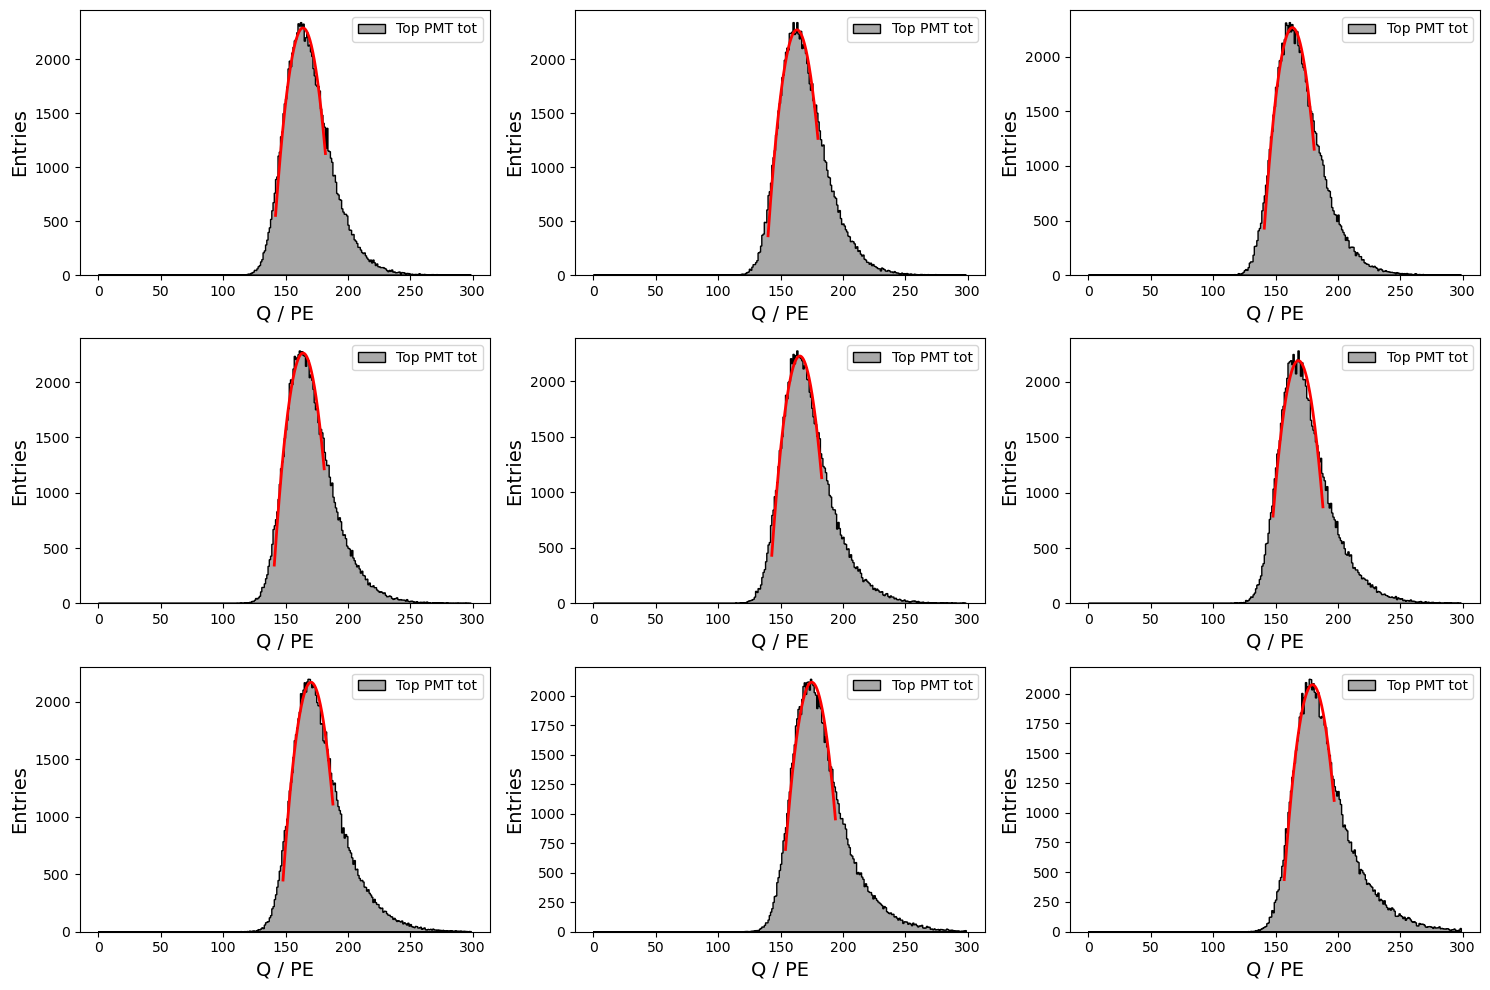

In [37]:
plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,300,FADC_BIN_WIDTH)
fadc_bin_centers = (fadc_bins_fit[:-1] + fadc_bins_fit[1:]) / 2.

low_count_threshold_array = [20, 20, 30, 30, 30, 30, 30, 30, 30]
low_count_threshold_array_min = [20, 20, 20, 30, 30, 30, 30, 30, 30]

range_width_low = [20, 20, 20, 20, 20, 20, 20, 20, 20]
range_width_hi = [20, 20, 20, 20, 20, 20, 20, 20, 20]

fadc_peak_bin = np.zeros(len(input_files))
rel_peak_err = np.zeros(len(input_files))
fadc_peak_entries = np.zeros(len(input_files))
fadc_peak_width = np.zeros(len(input_files))

fadc_peak_pos = np.zeros(len(input_files))

fadc_min_bin = np.zeros(len(input_files))
fadc_min_entries = np.zeros(len(input_files))

coinc = True 
min_npe_th = 0


for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_pmt(input_folder+file,"pmt4_FADC", minnpe=10)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    par, d_par, range = pol2_fit(pmt_tot, fadc_bins_fit, range_low=range_width_low[i], range_hi=range_width_hi[i], low_count_threshold=low_count_threshold_array[i])
    p0_fit, p1_fit, p2_fit = par
    p0_err, p1_err, p2_err = d_par

    # Compute fitted curve
    x_fit = np.linspace(range[0], range[1], 1000)
    y_fit = pol_2(x_fit, *par)

    print('Result of Gaussian fit')

    p0_err, p1_err, p2_err = d_par
    print('p0 =',p0_fit,' +-',p0_err)
    print('p1 =',p1_fit,' +-',p1_err)
    print('p2 =',p2_fit,' +-',p1_err)

    peak_parabola = -0.5 * par[1] / par[0]
    fadc_peak_pos[i] = peak_parabola
    print('Peak position is: ',peak_parabola)

    d_peak_parabola_rel = np.sqrt( (d_par[1]/par[1])**2 + (d_par[0]/par[0])**2 )

    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    #plt.plot(x_fit, y_fit, linewidth=2, label=f'Fit: μ={mu_fit:.2f}, σ={sigma_fit:.2f}',color='red')
    plt.plot(x_fit, y_fit, linewidth=2, color='red')
    plt.legend()
    plt.yscale('linear')
    plt.xlabel('Q / PE',size=14)
    plt.ylabel('Entries',size=14)

    fadc_peak_bin[i] = np.digitize(peak_parabola, fadc_bins_fit) - 1
    print(fadc_peak_bin[i])
    fadc_peak_entries[i] = entries[np.digitize(peak_parabola, fadc_bins_fit) - 1]

    ymax = - par[1]**2/(4*par[0]) + par[2]

    a = par[0]
    b = par[1]
    c = par[2] - ymax / 2.

    fwhm = np.sqrt(b**2 - 4 * a * c) / np.abs(a) 

    print('Peak width is : ',fwhm)

    fadc_min = find_valley(pmt_tot, low_threshold=low_count_threshold_array_min[i], peak_position=peak_parabola)
    print('Found minimum at ',fadc_min,'\n')
    fadc_min_bin[i] = np.digitize(fadc_min, fadc_bins_fit) - 1
    fadc_min_entries[i] = entries[np.digitize(fadc_min, fadc_bins_fit) -1]
##
    c = par[2] - fadc_min_entries[i]
    w_min = np.sqrt(b**2 - 4 * a * c) / np.abs(a) 
##
    print('Width at peak minimum: ',w_min,'\n')
##
    fadc_peak_width[i] = w_min


plt.tight_layout()
#plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/top_height_fit_pol2_PE.pdf')

In [38]:
print(fadc_peak_bin)
print(fadc_peak_entries)

[163. 163. 163. 164. 165. 168. 170. 175. 179.]
[2305. 2337. 2296. 2241. 2215. 2279. 2172. 2101. 2032.]


Max coordinates ( 163.5 ,  2305.0 )
Max coordinates ( 163.5 ,  2337.0 )
Max coordinates ( 163.5 ,  2296.0 )
Max coordinates ( 164.5 ,  2241.0 )
Max coordinates ( 165.5 ,  2215.0 )
Max coordinates ( 168.5 ,  2279.0 )
Max coordinates ( 170.5 ,  2172.0 )
Max coordinates ( 175.5 ,  2101.0 )
Max coordinates ( 179.5 ,  2032.0 )


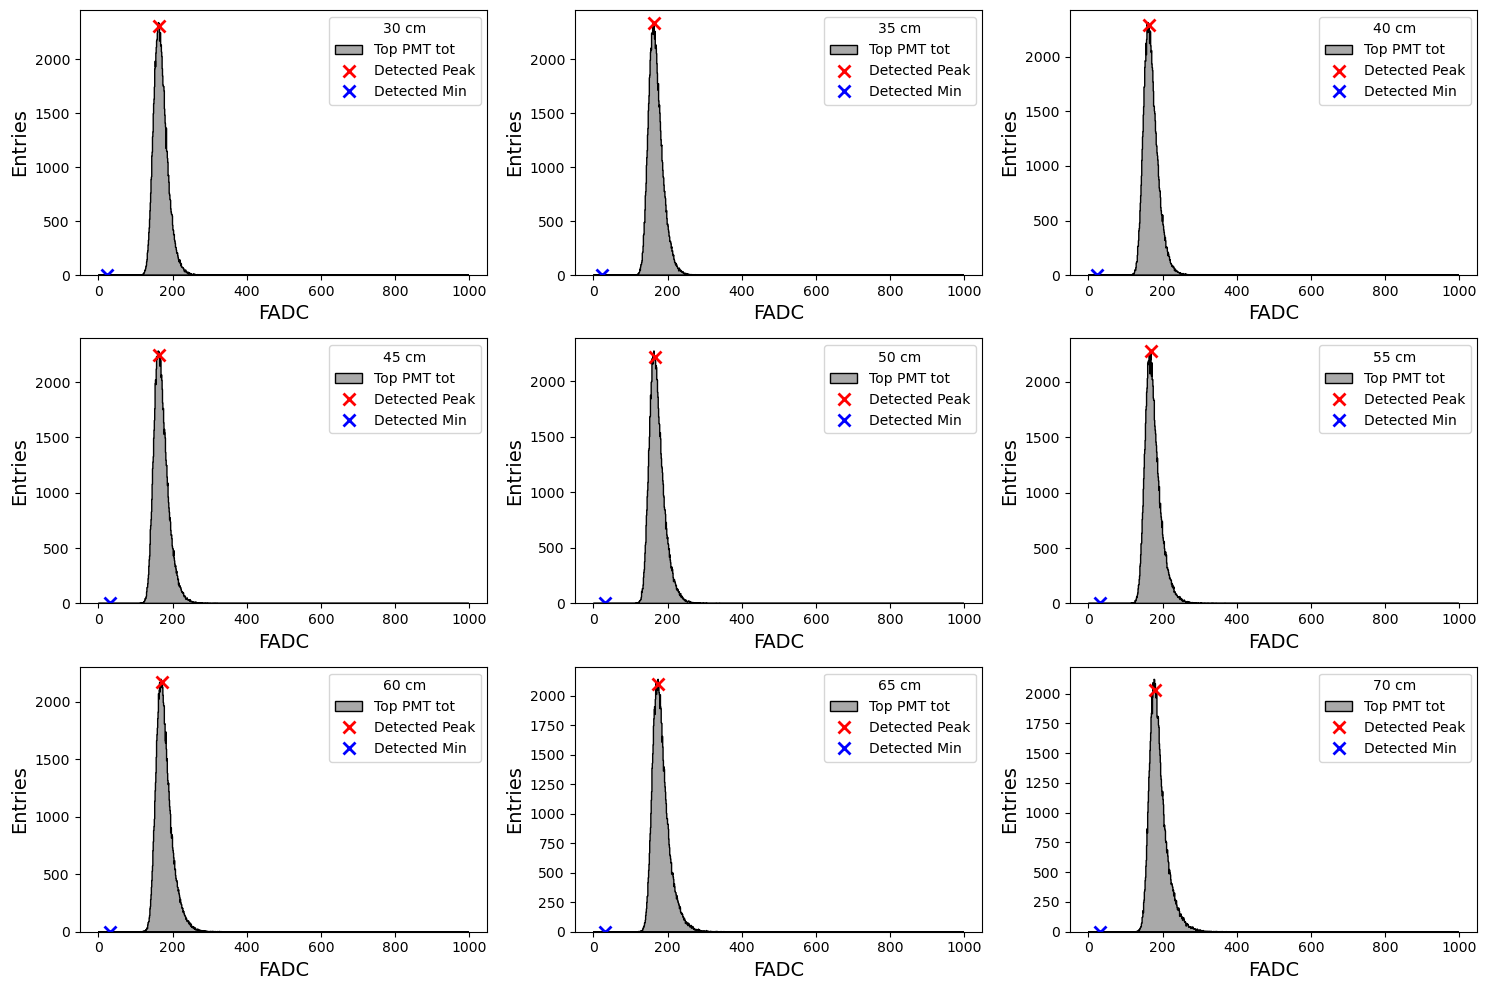

In [39]:
plt.subplots(3,3, figsize=(15,10))
fadc_bins_fit = np.arange(0,1000,FADC_BIN_WIDTH)

leg_title = ['30 cm','35 cm','40 cm','45 cm','50 cm','55 cm','60 cm','65 cm','70 cm']

for i, file in enumerate(input_files):

    plt.subplot(3,3,i+1)
    pmt_tot = load_pmt(input_folder+file,'pmt4_FADC', minnpe=10)
    #plt.hist(pmt_tot, bins=fadc_bins, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )

    i_peak_bin = int(fadc_peak_bin[i])
    i_min_bin = int(fadc_min_bin[i])

    print('Max coordinates (',fadc_bin_centers[i_peak_bin],', ',fadc_peak_entries[i],')')
    entries, bin, fig = plt.hist(pmt_tot, bins=fadc_bins_fit, color='darkgray',edgecolor='black',histtype= "stepfilled", label='Top PMT tot' )
    plt.plot(fadc_bin_centers[i_peak_bin], fadc_peak_entries[i], 'rx', label='Detected Peak', ms=8, mew=2)
    plt.plot(fadc_bin_centers[i_min_bin], fadc_min_entries[i], 'bx', label='Detected Min',ms=8, mew=2)

    plt.legend(title = leg_title[i])
    plt.yscale('linear')
    plt.xlabel('FADC',size=14)
    plt.ylabel('Entries',size=14)


plt.tight_layout()

plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/bottom_height_scan_max_min_PE.pdf')

[inf inf inf inf inf inf inf inf inf]
NpzFile '/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/calibration_arrays/peak_dip_ratio_PE.npz' with keys: top_height, ratio, ratio_err


/var/folders/9q/jx2z7jn52_75x5sl690z4ssm0000gn/T/ipykernel_88064/584587861.py:2: RuntimeWarning: divide by zero encountered in divide
  ratio = fadc_peak_entries / fadc_min_entries
/opt/anaconda3/envs/tank_env/lib/python3.12/site-packages/matplotlib/axes/_axes.py:3825: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err


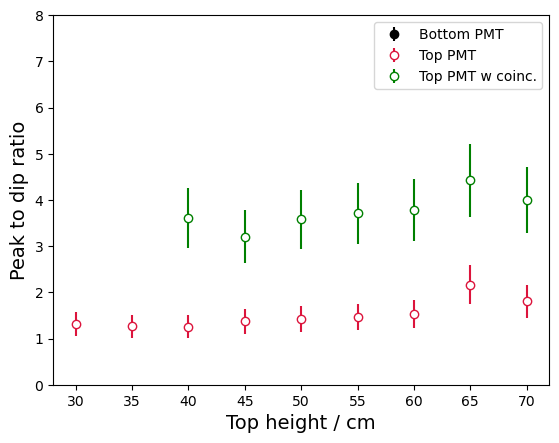

In [40]:

top_height = np.arange(30,75,5)
ratio = fadc_peak_entries / fadc_min_entries
print(ratio * d_peak_parabola_rel)
plt.errorbar(top_height, ratio, yerr = ratio * d_peak_parabola_rel, fmt='o',markerfacecolor='black', markeredgecolor='black', ecolor = 'black', label='Bottom PMT')
plt.xlabel('Top height / cm',size=14)
plt.ylabel('Peak to dip ratio',size=14)

plt.ylim(0,8)

top_pe = np.load('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/calibration_arrays/peak_dip_ratio_PE.npz')
print(top_pe)
plt.errorbar(top_pe['top_height'], top_pe['ratio'], yerr = top_pe['ratio_err'], fmt='o',markerfacecolor='white', markeredgecolor='crimson', ecolor = 'crimson', label='Top PMT')


top_pe_coinc = np.load('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/output/calibration_arrays/peak_dip_ratio_coinc_PE.npz')
plt.errorbar(top_pe_coinc['top_height'], top_pe_coinc['ratio'], yerr = top_pe_coinc['ratio_err'], fmt='o',markerfacecolor='white', markeredgecolor='green', ecolor = 'green', label='Top PMT w coinc.')


plt.legend()

plt.savefig('/Users/workspace/Software/Pierre_Tank/Top_Height_Scan/plots/bottom_height_scan_peak_dip_ratio_PE.pdf')
